In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import itertools
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
trans_df = pd.read_csv('/Users/mehrnazuser/Documents/Lavoro/BlueRock Logistics/Data/Trans_BLR.csv', usecols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], sep =';', encoding = 'utf-8')
#Type_List = ['COL', 'RET']
#trans_df = trans_df.loc[trans_df['T_DOC_TYPE'].isin(Type_List)]
trans_df = trans_df.loc[trans_df['T_DOC_TYPE'] == 'COL']

trans_df['T_EFFECTIVE_DATE'] = pd.to_datetime(trans_df['T_EFFECTIVE_DATE'])
trans_df['Date'] = trans_df.apply(lambda r:r['T_EFFECTIVE_DATE'].date(), axis = 1)
trans_df = trans_df.dropna(subset = ['Date'])

trans_df = trans_df[['Date', 'T_DOC_TYPE', 'T_SENDING_ID', 'T_RTI_NAME', 'T_ACT_HAND_OUT_QTY']]
trans_df = trans_df.reset_index()
trans_df = trans_df.drop('index', axis = 1)
#trans_df.head()

In [3]:
depot_add = pd.read_excel('/Users/mehrnazuser/Documents/Lavoro/BlueRock Logistics/Data/masterdata20190918.xlsx', sheet_name = 'Depot Account_Addreses')
depot_add = depot_add[['name', 'code', 'country']]
#depot_add.head()

In [4]:
# JOIN

trans_full = trans_df.join(depot_add.set_index('code'), on = 'T_SENDING_ID')
trans_full = trans_full.drop(['T_SENDING_ID', 'T_DOC_TYPE'], axis =1)
#trans_full.head()

# Filter Dataset:

### _ONLY Germany

In [5]:

trans_de = trans_full.loc[trans_full['country'] == 'DE']
trans_de = trans_de.sort_values('Date', ascending = True)
trans_de = trans_de.drop(['country'], axis = 1)
#trans_it.head()

In [91]:
trans_de['name'].nunique()

9

### _RTI = Container Base

In [6]:
de_cb = trans_de.loc[trans_de['T_RTI_NAME'] == 'CC Container Base']
de_cb = de_cb.drop(['T_RTI_NAME'], axis = 1)
de_cb['Date'] = pd.to_datetime(de_cb['Date'])
de_cb = de_cb.set_index('Date')
de_cb.head()

,T_ACT_HAND_OUT_QTY,name
Date,,
2014-07-01,41,DE-Lüllingen Landgard
2014-07-01,40,DE-Lüllingen Landgard
2014-07-01,43,DE-Lüllingen Landgard
2014-07-01,42,DE-Lüllingen Landgard
2014-07-01,42,DE-Lüllingen Landgard


Text(0.5, 1.0, 'CB_DE Jul 2014--Jul 2019')

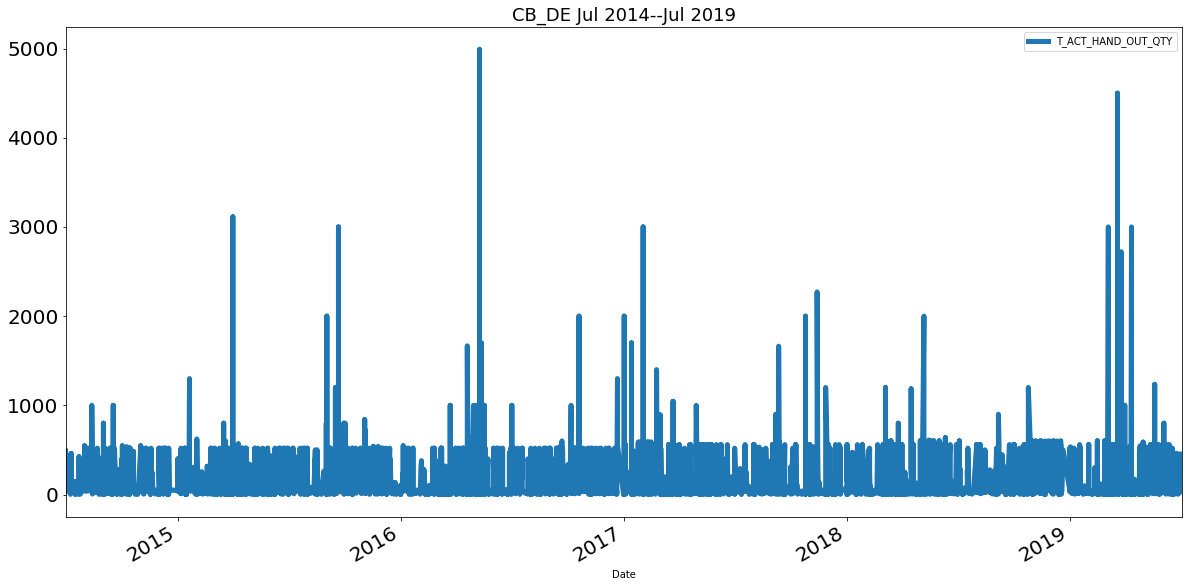

In [7]:
de_cb.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.title("CB_DE Jul 2014--Jul 2019", fontsize = 18)

## Monthly from 2017 on

Text(0.5, 1.0, 'CB_DE : Jan 2017--Jul 2019')

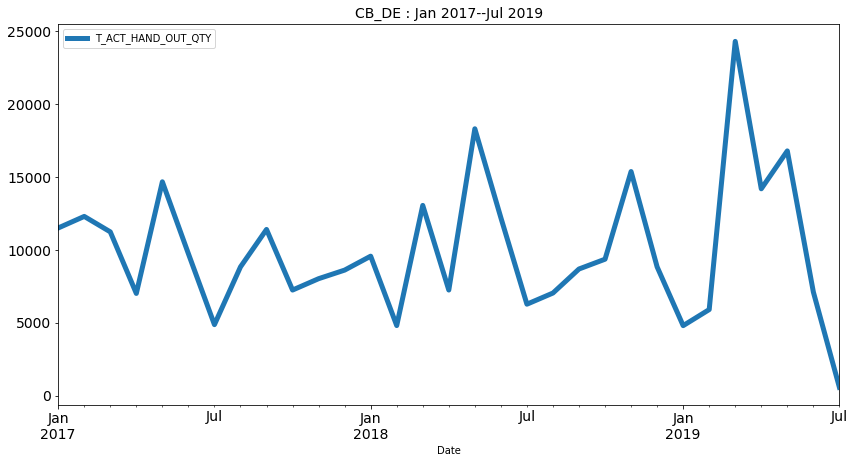

In [8]:
import datetime
de_cbm = de_cb.resample('1M').sum()
de_cb_m = de_cbm[(de_cbm.index >= datetime.datetime(2017,1,31))]
de_cb_m.plot(figsize=(14,7), linewidth=5, fontsize=14)
plt.title("CB_DE : Jan 2017--Jul 2019", fontsize = 14)

In [9]:
#de_cb_m.to_excel(r'/Users/mehrnazuser/Google Drive/BlueRock-Mehrnaz/Code/2excel/DE/DE_before_2019_Aug.xlsx')

In [10]:
de_cb_m.index

DatetimeIndex(['2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31',
               '2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31',
               '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31'],
              dtype='datetime64[ns]', name='Date', freq='M')

## Seasonal Decompose 2017

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
from chart_studio.plotly import plot_mpl
result = seasonal_decompose(de_cb_m, model='multiplicative')
#fig = result.plot()
#plot_mpl(fig)

Text(0.5, 1.0, 'Residual')

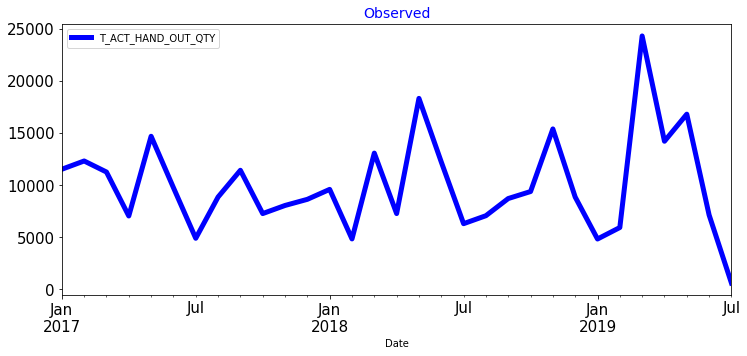

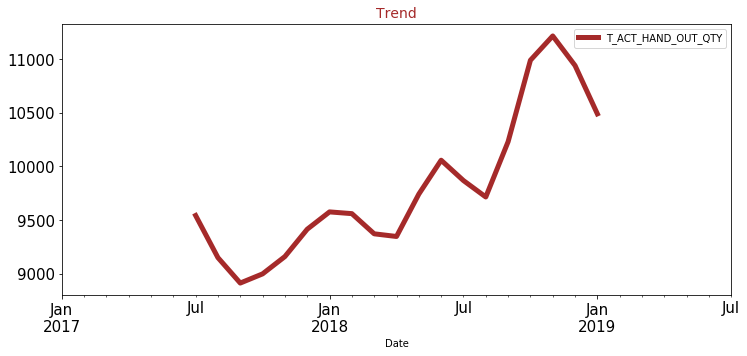

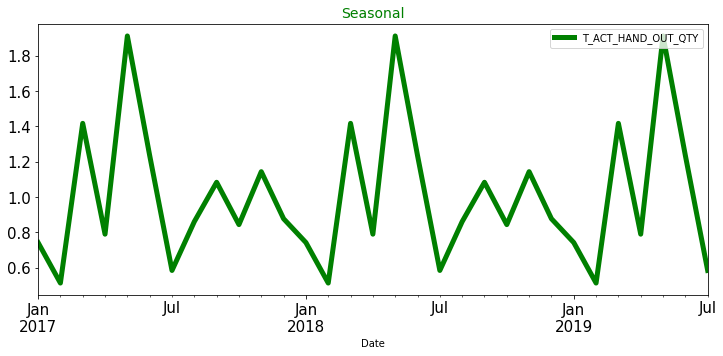

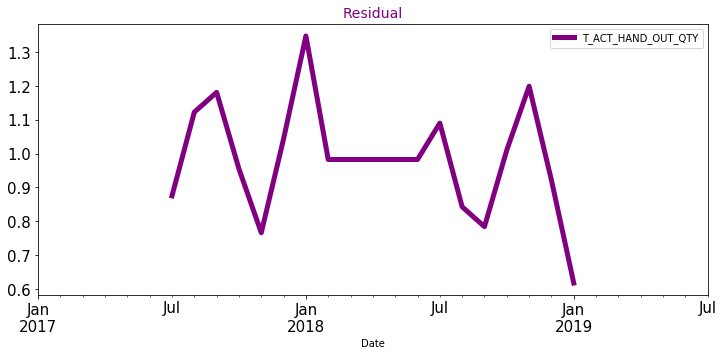

In [12]:
result.observed.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'blue')
plt.title('Observed', fontsize = 14, color ='blue')

result.trend.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'brown')
plt.title('Trend', fontsize = 14 , color = 'brown')

result.seasonal.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'green')
plt.title('Seasonal', fontsize = 14 , color = 'green')

result.resid.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'purple')
plt.title('Residual', fontsize = 14 , color = 'purple')

## SARIMA

In [13]:
#from pyramid.arima import auto_arima
import pmdarima.arima as arima
stepwise_model = arima.auto_arima(de_cb_m, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=364.003, BIC=365.783, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=366.864, BIC=370.425, Fit time=0.034 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=362.034, BIC=362.925, Fit time=0.010 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=365.337, BIC=368.008, Fit time=0.027 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=365.841, BIC=368.512, Fit time=0.015 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=364.928, BIC=367.599, Fit

In [14]:
#it_cb_m.index

In [15]:
model_fit = stepwise_model.fit(de_cb_m)
model_fit

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 1, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

# fix from here....

In [16]:
future_forecast = stepwise_model.predict(n_periods=12)
future_forecast = pd.DataFrame(future_forecast)
future_forecast['Date'] = pd.date_range('2019-08-31', periods=12, freq='M')

In [17]:
future_forecast = future_forecast.set_index('Date')

In [18]:
future_forecast = future_forecast.rename(columns={0: "DE_2019_Aug_on"})

In [19]:
future_forecast

,DE_2019_Aug_on
Date,
2019-08-31,1343.0
2019-09-30,2991.0
2019-10-31,3663.0
2019-11-30,9675.0
2019-12-31,3137.0
2020-01-31,-895.0
2020-02-29,208.0
2020-03-31,18604.0
2020-04-30,8492.0


In [20]:
future_forecast = future_forecast.where(future_forecast > 0, 0)
future_forecast

,DE_2019_Aug_on
Date,
2019-08-31,1343.0
2019-09-30,2991.0
2019-10-31,3663.0
2019-11-30,9675.0
2019-12-31,3137.0
2020-01-31,0.0
2020-02-29,208.0
2020-03-31,18604.0
2020-04-30,8492.0


Text(0.5, 1.0, '2019 Prediction of DE-CB')

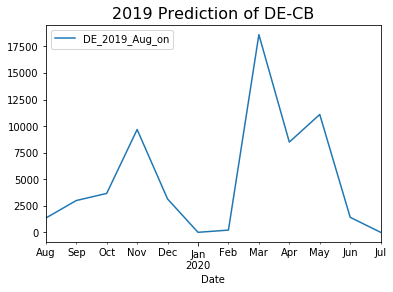

In [21]:
#future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
#pd.concat([test,future_forecast],axis=1).plot(figsize=(14,7), linewidth=5, fontsize=15)
future_forecast.plot()
plt.title('2019 Prediction of DE-CB', fontsize = 16)

In [22]:
#future_forecast.to_excel(r'/Users/mehrnazuser/Google Drive/BlueRock-Mehrnaz/Code/2excel/DE/DE_2019_Aug_on.xlsx')

In [23]:
model_fit.aic

<function pmdarima.arima.arima.ARIMA.aic(self)>

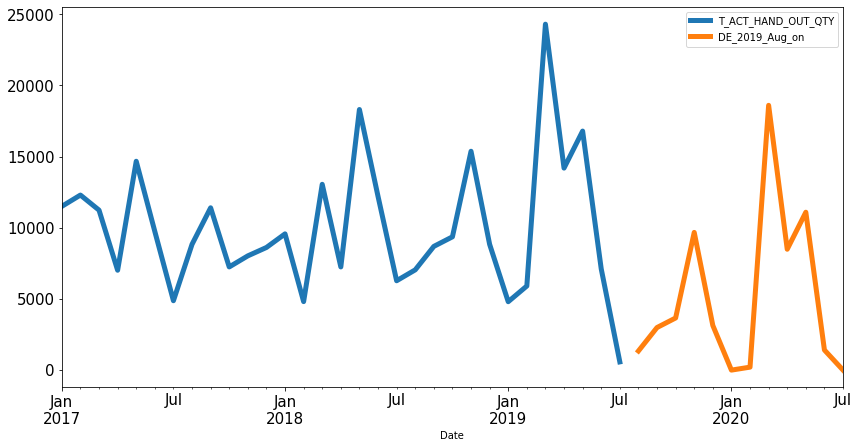

In [24]:
pd.concat([de_cb_m,future_forecast],axis=1).plot(figsize=(14,7), linewidth=5, fontsize=15)

## DEPOTS

In [25]:
trans_de['Date'] = pd.to_datetime(trans_de['Date'])

In [26]:
#trans_it.to_excel(r'/Users/mehrnazuser/Google Drive/BlueRock-Mehrnaz/Code/2excel/trans_it.xlsx')

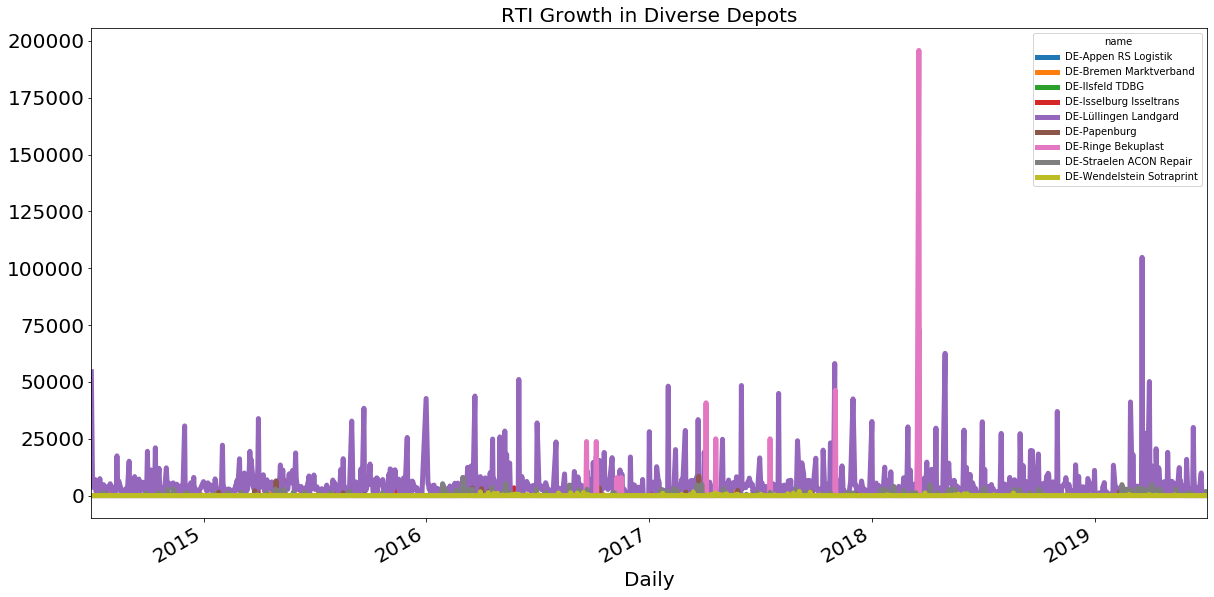

In [27]:
(trans_de.groupby(['Date', 'name'])['T_ACT_HAND_OUT_QTY']
   .sum()
   .unstack('name', fill_value=0)
   .plot(figsize=(20,10), linewidth=5, fontsize=20))
plt.title('RTI Growth in Diverse Depots', fontsize=20)
plt.xlabel('Daily', fontsize=20)
plt.show()

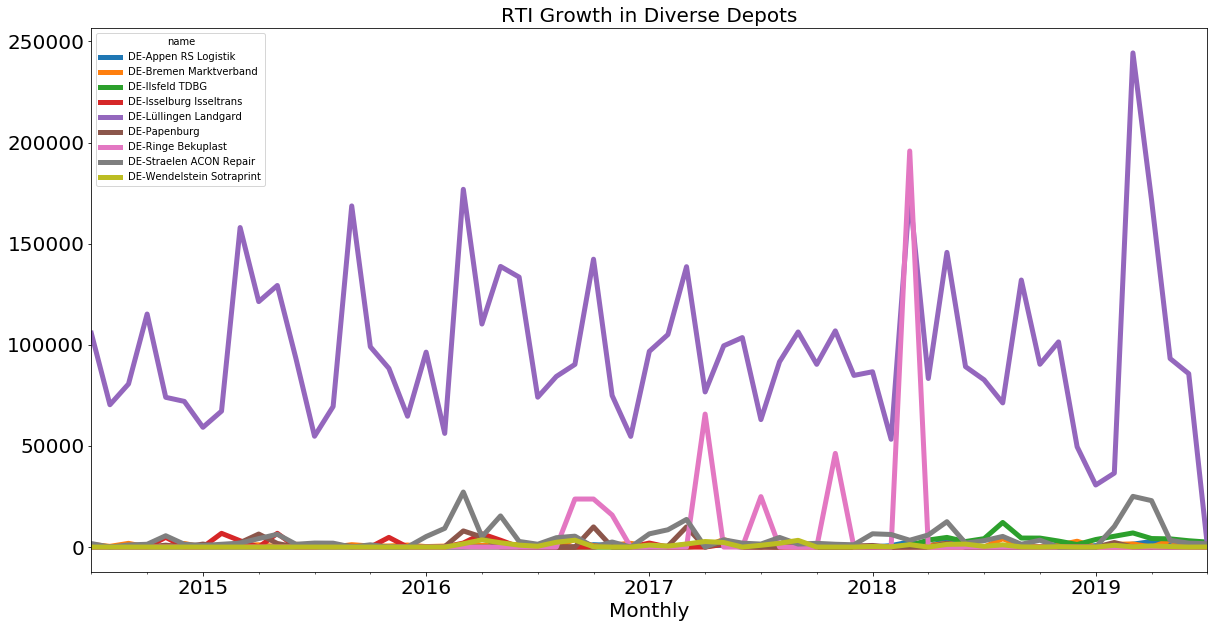

In [28]:
de_deps = trans_de.groupby(['Date', 'name'])['T_ACT_HAND_OUT_QTY'].sum().unstack('name', fill_value=0)
de_deps_month = de_deps.resample('1M').sum()
de_deps_month.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.title('RTI Growth in Diverse Depots', fontsize=20)
plt.xlabel('Monthly', fontsize=20)
plt.show()

Text(0.5, 1.0, 'CB_DE : Jan 2017--Jul 2019')

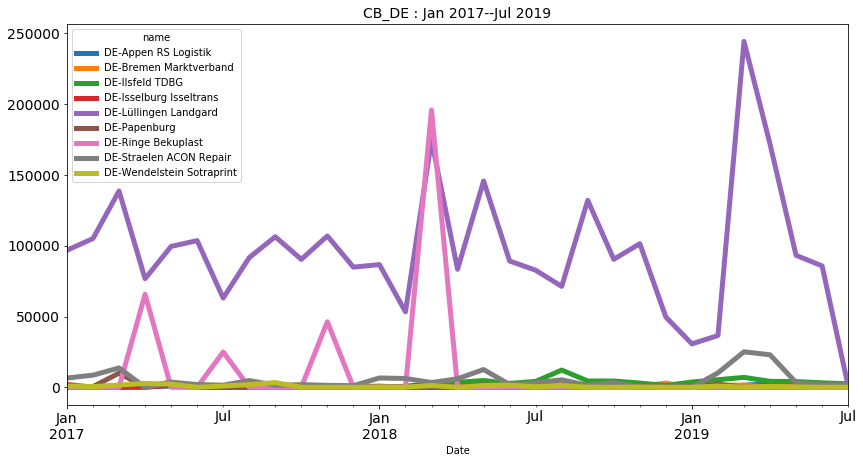

In [29]:
import datetime
de_cb2017 = de_deps_month[(de_cbm.index >= datetime.datetime(2017,1,31))]
de_cb2017.plot(figsize=(14,7), linewidth=5, fontsize=14)
plt.title("CB_DE : Jan 2017--Jul 2019", fontsize = 14)

In [30]:
depos = trans_de['name'].unique()

In [31]:
def optimal_sarima(depot):
    
    stepwise_model = arima.auto_arima(depot, start_p=1, start_q=1,
                               max_p=3, max_q=3, m=6,
                               start_P=0, seasonal=True,
                               d=1, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    return stepwise_model
    #print(stepwise_model.aic())

In [33]:
opt_sarima_deps = []
for i in range(0,len(depos)):
    dep = de_cb2017[[depos[i]]].dropna()
    print('\n ' + depos[i] + ': ')
    print('\n')
    opt_sarima = optimal_sarima(dep)
    print(opt_sarima.aic())
    opt_sarima_deps.append(opt_sarima)


 DE-Lüllingen Landgard: 


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=593.359, BIC=599.249, Fit time=0.079 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=597.199, BIC=599.555, Fit time=0.006 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 6); AIC=591.506, BIC=596.218, Fit time=0.025 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=592.253, BIC=596.966, Fit time=0.027 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=596.057, BIC=597.235, Fit time=0.005 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=592.564, BIC=596.098, Fit time=0.012 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 6); AIC=592.693, BIC=598.583, Fit time=0.045 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 6); AIC=592.722, BIC=598.612, Fit time=0.059 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 6); AIC=592.785, BIC=597.497, Fit time=0.025 seconds
Fit ARIMA: order=(1, 1, 0) 

Fit ARIMA: order=(0, 1, 2) seasonal_order=(2, 1, 1, 6); AIC=500.846, BIC=509.092, Fit time=0.314 seconds
Fit ARIMA: order=(0, 1, 3) seasonal_order=(1, 1, 0, 6); AIC=500.127, BIC=507.195, Fit time=0.140 seconds
Total fit time: 3.649 seconds
496.6114875554558

 DE-Bremen Marktverband: 


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=420.683, BIC=426.574, Fit time=0.207 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=445.068, BIC=447.424, Fit time=0.005 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 6); AIC=424.559, BIC=429.271, Fit time=0.104 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=419.125, BIC=423.837, Fit time=0.214 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=443.071, BIC=444.249, Fit time=0.007 seconds
Fit ARIMA: order=(1, 1, 1) sea

Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 6); AIC=414.293, BIC=419.006, Fit time=0.108 seconds
Near non-invertible roots for order (1, 1, 0)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=410.326, BIC=417.394, Fit time=0.199 seconds
Near non-invertible roots for order (2, 1, 1)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 1, 6); AIC=411.873, BIC=418.941, Fit time=0.212 seconds
Near non-invertible roots for order (1, 1, 2)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 6); AIC=414.767, BIC=418.301, Fit time=0.054 seconds
Near non-invertible roots for order (0, 1, 0)(0, 1, 1, 6); setting score to inf (at least one inverse root

Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 0, 6); AIC=453.874, BIC=459.764, Fit time=0.205 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 6); AIC=453.939, BIC=459.830, Fit time=0.133 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 6); AIC=453.777, BIC=458.490, Fit time=0.184 seconds
Near non-invertible roots for order (1, 1, 0)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 1, 1, 6); AIC=456.180, BIC=463.249, Fit time=0.278 seconds
Near non-invertible roots for order (1, 1, 0)(2, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 6); AIC=453.304, BIC=456.838, Fit time=0.041 seconds
Near non-invertible roots for order (0, 1, 0)(1, 1, 0, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
F

In [35]:
optimal_test = list()
optimal_prediction = list()
opt_deps_forecast_aug2019on = list()
#depo_train = list()
#depo_test = list()
mse = list()

for f in range(0, len(depos)):
    dep = de_cb2017[[depos[f]]].dropna()
    
    model_fit = opt_sarima_deps[f].fit(dep)

    depo_forecast_aug2019on = model_fit.predict(n_periods=12)
    
    for col in range(len(depo_forecast_aug2019on)):
        if depo_forecast_aug2019on[col] < 0:
            depo_forecast_aug2019on[col] = 0
    
    opt_deps_forecast_aug2019on.append(depo_forecast_aug2019on)


In [38]:
depots_forecasts_aug2019on = pd.DataFrame()

In [39]:
for i in range(0, len(depos)):
    depots_forecasts_aug2019on[depos[i]] = opt_deps_forecast_aug2019on[i]

In [45]:
depots_forecasts_aug2019on['Date'] = pd.date_range('2019-08-31', periods=12, freq='M')
depots_forecasts_aug2019on = depots_forecasts_aug2019on.set_index('Date')
depots_forecasts_aug2019on

,DE-Lüllingen Landgard,DE-Isselburg Isseltrans,DE-Straelen ACON Repair,DE-Bremen Marktverband,DE-Papenburg,DE-Wendelstein Sotraprint,DE-Appen RS Logistik,DE-Ringe Bekuplast,DE-Ilsfeld TDBG
Date,,,,,,,,,
2019-08-31,40290.970801,17.343422,7835.517679,1366.478037,289.615650,238.718091,149.633090,8088.884435,10374.947418
2019-09-30,182828.543784,82.062129,15715.159307,931.855455,1918.590045,568.459966,1076.237694,44668.831863,4356.886270
2019-10-31,124476.289816,154.482237,15023.357168,708.135024,16.517328,45.648663,0.000000,25733.250994,3785.009700
2019-11-30,86357.724122,487.872758,7520.514229,2249.066499,778.829636,144.927471,1180.639671,29591.597307,2513.430530
2019-12-31,59493.869397,282.618433,5371.244210,1149.656241,221.090383,0.000000,0.000000,28429.513483,891.972123
2020-01-31,4501.337960,580.770927,6228.767720,488.304096,245.673402,0.000000,169.764644,36921.017617,2747.555115
2020-02-29,29349.783736,344.550195,11828.043741,1398.153374,719.508754,77.063269,191.693217,42189.148039,5482.907655
2020-03-31,201421.204418,432.365505,17920.324980,958.028638,2385.651736,411.018085,1055.270519,81485.634714,5657.489414
2020-04-30,137137.209319,527.882215,17276.424221,728.806054,520.747607,0.000000,1319.493961,64351.097191,3255.167541


In [46]:
def plot_depo_prediction(depo_name, depo_test, depo_pred):
        pd.concat([depo_test, depo_pred], axis=1).plot(figsize=(10,5), linewidth=5, fontsize=14)
        plt.title('2019 Prediction of ' + depo_name, fontsize = 14)  

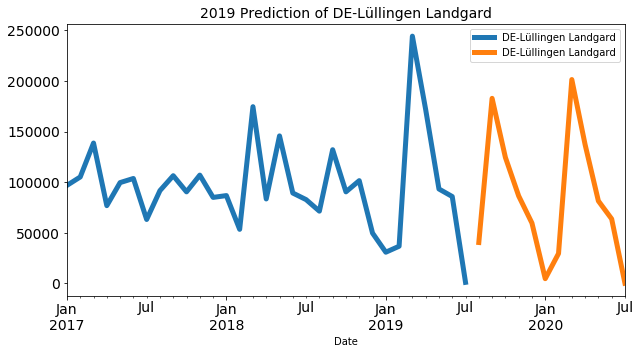

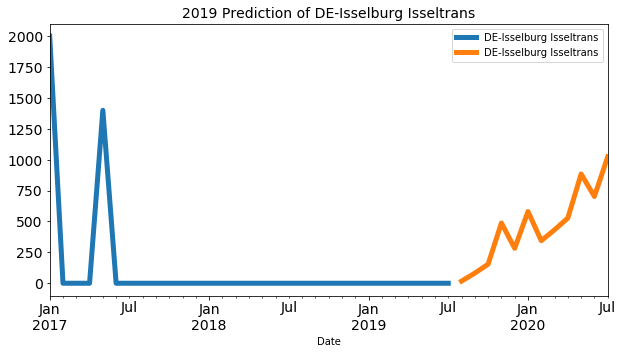

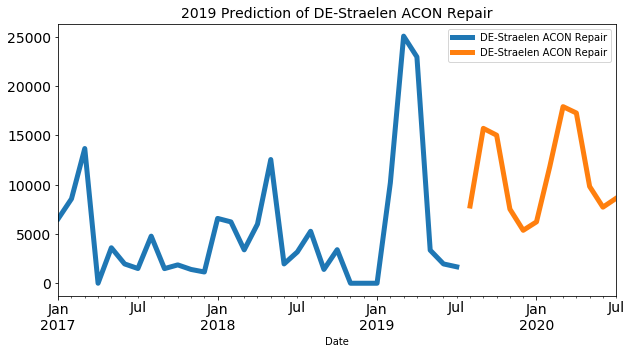

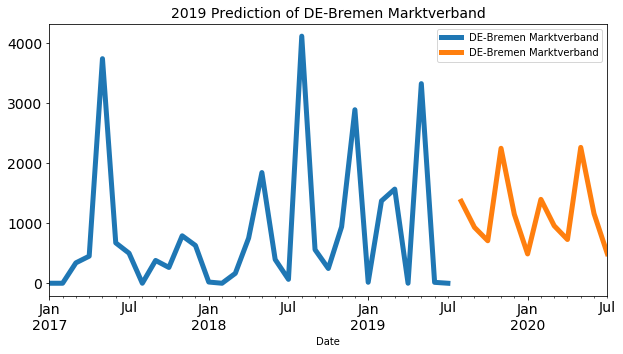

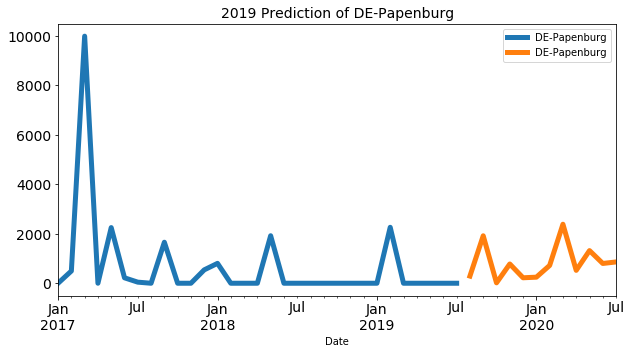

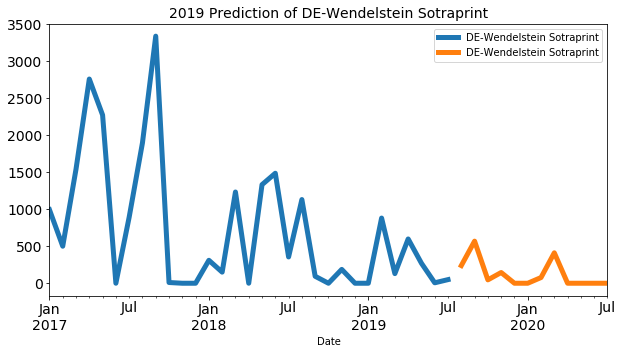

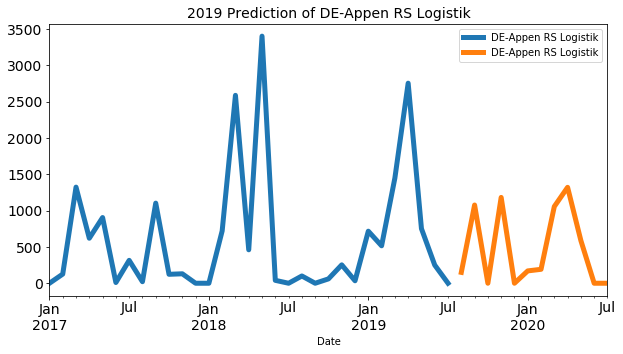

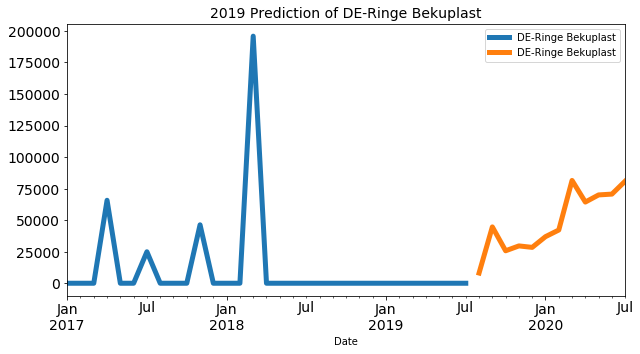

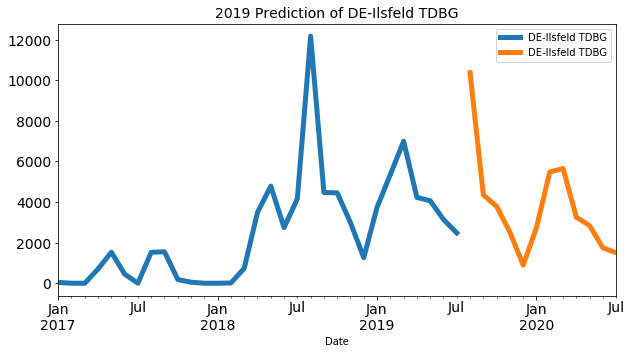

In [59]:
#depos_mse = list()
for j in range(0, len(depos)):
    plot_depo_prediction(depos[j], de_cb2017[[depos[j]]], depots_forecasts_aug2019on[[depos[j]]])
    #mse = mean_squared_error(depo_test[j], depots_forecasts[[depos[j]]])
    #depos_mse.append(mse)

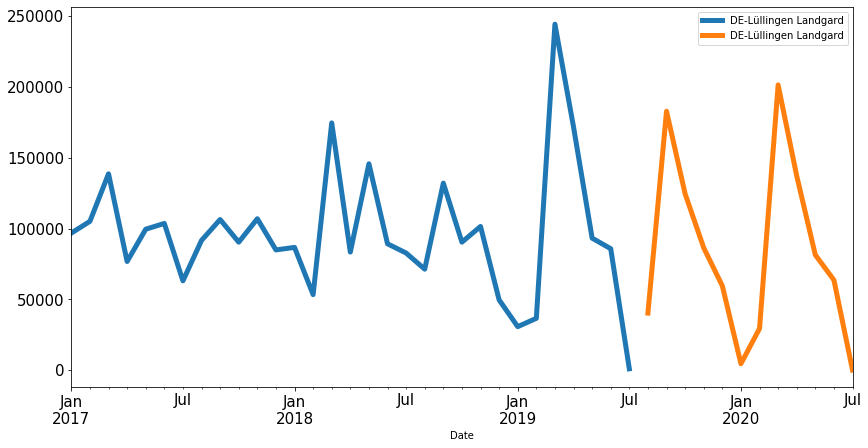

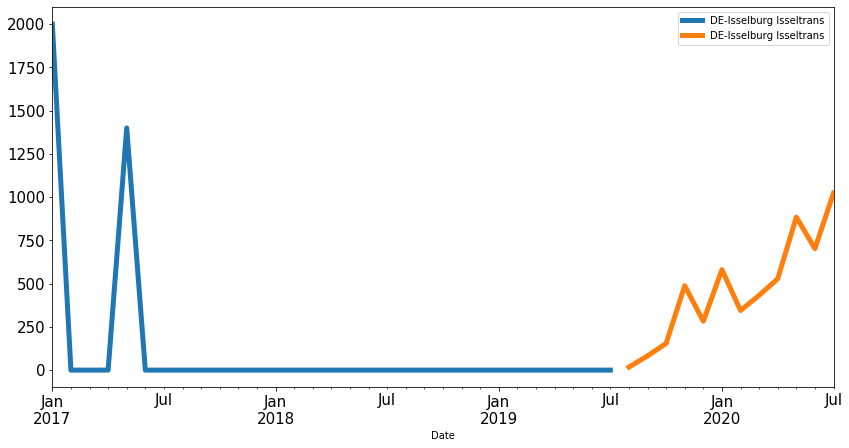

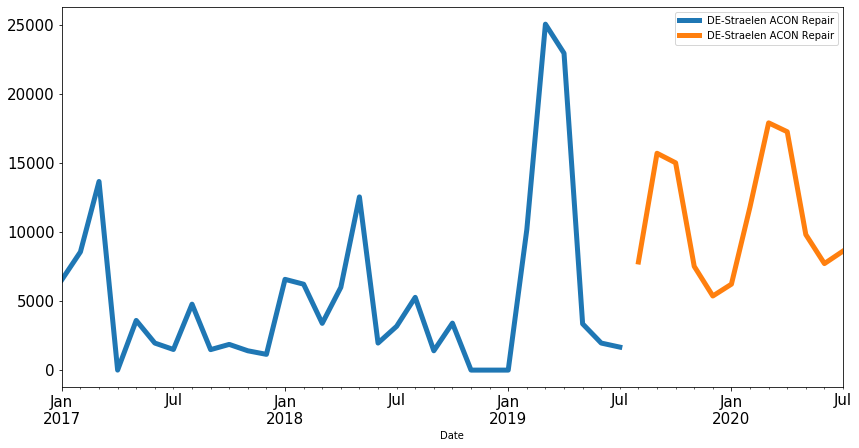

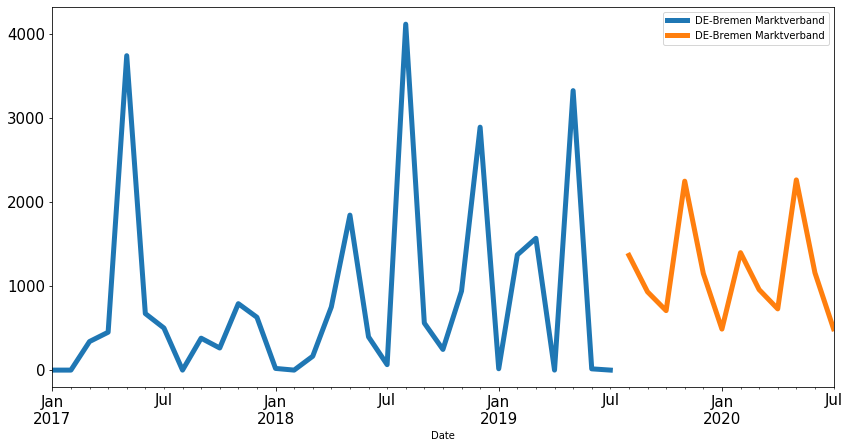

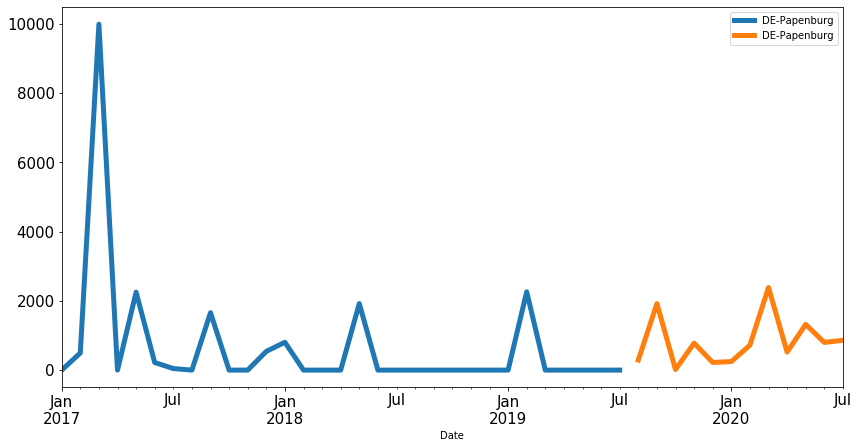

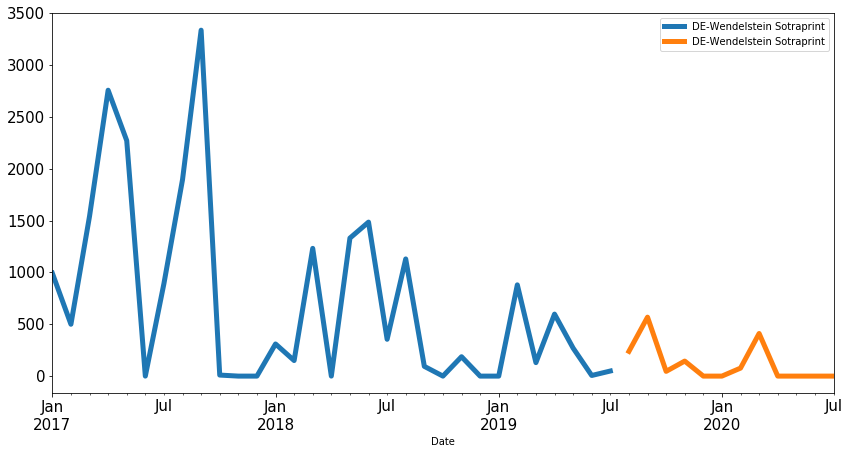

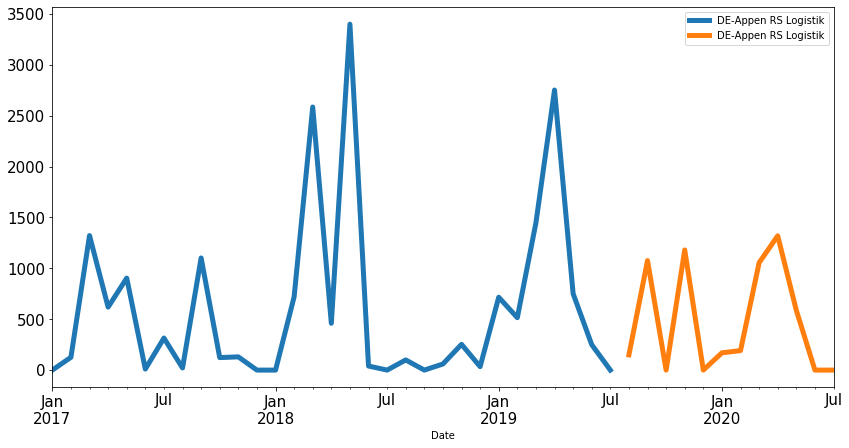

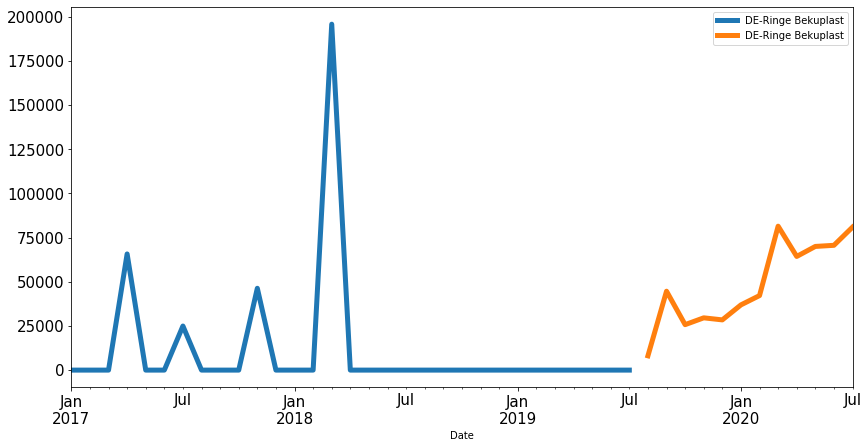

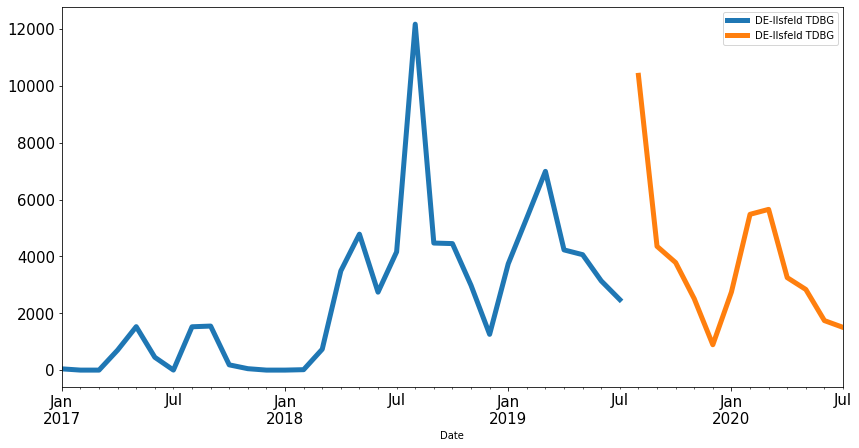

In [49]:
for s in range(0, len(depos)):
    pd.concat([de_cb2017[[depos[s]]], depots_forecasts_aug2019on[[depos[s]]]],axis=1).plot(figsize=(14,7), linewidth=5, fontsize=15)

In [51]:
depots_forecasts_aug2019on['DE_by_Sum'] = depots_forecasts_aug2019on.sum(axis=1)

depots_forecasts_aug2019on

,DE-Lüllingen Landgard,DE-Isselburg Isseltrans,DE-Straelen ACON Repair,DE-Bremen Marktverband,DE-Papenburg,DE-Wendelstein Sotraprint,DE-Appen RS Logistik,DE-Ringe Bekuplast,DE-Ilsfeld TDBG,DE_by_Sum
Date,,,,,,,,,,
2019-08-31,40290.970801,17.343422,7835.517679,1366.478037,289.615650,238.718091,149.633090,8088.884435,10374.947418,68652.108621
2019-09-30,182828.543784,82.062129,15715.159307,931.855455,1918.590045,568.459966,1076.237694,44668.831863,4356.886270,252146.626514
2019-10-31,124476.289816,154.482237,15023.357168,708.135024,16.517328,45.648663,0.000000,25733.250994,3785.009700,169942.690931
2019-11-30,86357.724122,487.872758,7520.514229,2249.066499,778.829636,144.927471,1180.639671,29591.597307,2513.430530,130824.602223
2019-12-31,59493.869397,282.618433,5371.244210,1149.656241,221.090383,0.000000,0.000000,28429.513483,891.972123,95839.964271
2020-01-31,4501.337960,580.770927,6228.767720,488.304096,245.673402,0.000000,169.764644,36921.017617,2747.555115,51883.191482
2020-02-29,29349.783736,344.550195,11828.043741,1398.153374,719.508754,77.063269,191.693217,42189.148039,5482.907655,91580.851979
2020-03-31,201421.204418,432.365505,17920.324980,958.028638,2385.651736,411.018085,1055.270519,81485.634714,5657.489414,311726.988009
2020-04-30,137137.209319,527.882215,17276.424221,728.806054,520.747607,0.000000,1319.493961,64351.097191,3255.167541,225116.828108


In [87]:
depots_forecasts_aug2019on.to_excel(r'/Users/mehrnazuser/Google Drive/BlueRock-Mehrnaz/Code/2excel/DE/DE_depos_SARIMA&OLS_aug2019on.xlsx')

# OLS

In [53]:
import statsmodels.api as sm

In [55]:
XVar = de_cb2017.drop('DE-Lüllingen Landgard', axis = 1)
YVar = de_cb2017['DE-Lüllingen Landgard']
YVar.head()

Date
2017-01-31     96771
2017-02-28    105082
2017-03-31    138632
2017-04-30     76708
2017-05-31     99516
Freq: M, Name: DE-Lüllingen Landgard, dtype: int64

In [56]:
XVar.head()

name,DE-Appen RS Logistik,DE-Bremen Marktverband,DE-Ilsfeld TDBG,DE-Isselburg Isseltrans,DE-Papenburg,DE-Ringe Bekuplast,DE-Straelen ACON Repair,DE-Wendelstein Sotraprint
Date,,,,,,,,
2017-01-31,0,0,44,2000,0,0,6547,993
2017-02-28,126,0,0,0,495,0,8568,500
2017-03-31,1322,340,0,0,9990,0,13671,1541
2017-04-30,619,451,704,0,0,65760,0,2757
2017-05-31,904,3743,1529,1400,2250,0,3600,2271


In [57]:
linearModel = sm.OLS(YVar, XVar).fit()

In [68]:
print(linearModel.summary())

                                  OLS Regression Results                                  
Dep. Variable:     DE-Lüllingen Landgard   R-squared (uncentered):                   0.819
Model:                               OLS   Adj. R-squared (uncentered):              0.756
Method:                    Least Squares   F-statistic:                              13.03
Date:                   Mon, 17 Feb 2020   Prob (F-statistic):                    6.76e-07
Time:                           11:59:29   Log-Likelihood:                         -376.31
No. Observations:                     31   AIC:                                      768.6
Df Residuals:                         23   BIC:                                      780.1
Df Model:                              8                                                  
Covariance Type:               nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.9

In [81]:
X_sig = de_cb2017.drop(['DE-Appen RS Logistik', 'DE-Bremen Marktverband','DE-Ilsfeld TDBG', 'DE-Isselburg Isseltrans', 'DE-Papenburg', 'DE-Lüllingen Landgard'], axis = 1)

In [82]:
linearModel1 = sm.OLS(YVar, X_sig).fit()

In [83]:
print(linearModel1.summary())

                                  OLS Regression Results                                  
Dep. Variable:     DE-Lüllingen Landgard   R-squared (uncentered):                   0.783
Model:                               OLS   Adj. R-squared (uncentered):              0.760
Method:                    Least Squares   F-statistic:                              33.64
Date:                   Mon, 17 Feb 2020   Prob (F-statistic):                    2.01e-09
Time:                           12:03:52   Log-Likelihood:                         -379.16
No. Observations:                     31   AIC:                                      764.3
Df Residuals:                         28   BIC:                                      768.6
Df Model:                              3                                                  
Covariance Type:               nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.9

In [84]:
depots_forecasts_aug2019on['OLSed_Lüllingen'] = 0.6189*depots_forecasts_aug2019on['DE-Ringe Bekuplast'] + 9.0551*depots_forecasts_aug2019on['DE-Straelen ACON Repair'] + 24.0635 * depots_forecasts_aug2019on['DE-Wendelstein Sotraprint']

In [85]:
depots_forecasts_aug2019on

,DE-Lüllingen Landgard,DE-Isselburg Isseltrans,DE-Straelen ACON Repair,DE-Bremen Marktverband,DE-Papenburg,DE-Wendelstein Sotraprint,DE-Appen RS Logistik,DE-Ringe Bekuplast,DE-Ilsfeld TDBG,DE_by_Sum,OLSed_Lüllingen
Date,,,,,,,,,,,
2019-08-31,40290.970801,17.343422,7835.517679,1366.478037,289.615650,238.718091,149.633090,8088.884435,10374.947418,68652.108621,81701.999493
2019-09-30,182828.543784,82.062129,15715.159307,931.855455,1918.590045,568.459966,1076.237694,44668.831863,4356.886270,252146.626514,183627.015465
2019-10-31,124476.289816,154.482237,15023.357168,708.135024,16.517328,45.648663,0.000000,25733.250994,3785.009700,169942.690931,153062.777146
2019-11-30,86357.724122,487.872758,7520.514229,2249.066499,778.829636,144.927471,1180.639671,29591.597307,2513.430530,130824.602223,89900.710166
2019-12-31,59493.869397,282.618433,5371.244210,1149.656241,221.090383,0.000000,0.000000,28429.513483,891.972123,95839.964271,66232.179339
2020-01-31,4501.337960,580.770927,6228.767720,488.304096,245.673402,0.000000,169.764644,36921.017617,2747.555115,51883.191482,79252.532380
2020-02-29,29349.783736,344.550195,11828.043741,1398.153374,719.508754,77.063269,191.693217,42189.148039,5482.907655,91580.851979,135069.394576
2020-03-31,201421.204418,432.365505,17920.324980,958.028638,2385.651736,411.018085,1055.270519,81485.634714,5657.489414,311726.988009,222592.327735
2020-04-30,137137.209319,527.882215,17276.424221,728.806054,520.747607,0.000000,1319.493961,64351.097191,3255.167541,225116.828108,196266.643019


,DE-Lüllingen Landgard,DE-Isselburg Isseltrans,DE-Straelen ACON Repair,DE-Bremen Marktverband,DE-Papenburg,DE-Wendelstein Sotraprint,DE-Appen RS Logistik,DE-Ringe Bekuplast,DE-Ilsfeld TDBG,DE_by_Sum,OLSed_Lüllingen
Date,,,,,,,,,,,
2019-08-31,40290.970801,17.343422,7835.517679,1366.478037,289.615650,238.718091,149.633090,8088.884435,10374.947418,68652.108621,81701.999493
2019-09-30,182828.543784,82.062129,15715.159307,931.855455,1918.590045,568.459966,1076.237694,44668.831863,4356.886270,252146.626514,183627.015465
2019-10-31,124476.289816,154.482237,15023.357168,708.135024,16.517328,45.648663,0.000000,25733.250994,3785.009700,169942.690931,153062.777146
2019-11-30,86357.724122,487.872758,7520.514229,2249.066499,778.829636,144.927471,1180.639671,29591.597307,2513.430530,130824.602223,89900.710166
2019-12-31,59493.869397,282.618433,5371.244210,1149.656241,221.090383,0.000000,0.000000,28429.513483,891.972123,95839.964271,66232.179339
2020-01-31,4501.337960,580.770927,6228.767720,488.304096,245.673402,0.000000,169.764644,36921.017617,2747.555115,51883.191482,79252.532380
2020-02-29,29349.783736,344.550195,11828.043741,1398.153374,719.508754,77.063269,191.693217,42189.148039,5482.907655,91580.851979,135069.394576
2020-03-31,201421.204418,432.365505,17920.324980,958.028638,2385.651736,411.018085,1055.270519,81485.634714,5657.489414,311726.988009,222592.327735
2020-04-30,137137.209319,527.882215,17276.424221,728.806054,520.747607,0.000000,1319.493961,64351.097191,3255.167541,225116.828108,196266.643019


In [88]:
depots_forecasts_aug2019on.to_excel(r'/Users/mehrnazuser/Google Drive/BlueRock-Mehrnaz/Code/2excel/DE/OLSed_DE.xlsx')